In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
from operator import itemgetter

import helper
from IPython.display import display, HTML
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [3]:
df_orig = helper.get_data()

In [4]:
df_orig.shape

(18110, 20)

In [5]:
df = helper.get_cluster_df(df_orig, idx = 41, expected_cluster = 25) # 25 clusters
df = df.replace({"state": {'NSW1':'NSW', 'QLD1':'QLD', 'SA1':'SA', 'TAS1':'TAS', 'VIC1':'VIC'}})
fuel_cols = ['wind', 'solar', 'solar_rooftop','blackcoal', 'browncoal','gas','diesel','kerosene','hydro','bagasse','batterys', 'net_import']
additional_cols = ['demand', 'rrp', 'export']

/home/nandy/repository/git/replication/helper.py:110: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fossil = df_fossil.groupby(['clust'])['fossil','green'].sum().sort_values('fossil', ascending = False)


## Figure 1 - Data cross section

In [6]:
X = df[fuel_cols + ['state']]#df_orig.groupby('state').apply(lambda x: x.sample(100)).reset_index(drop=True)
print_cols = ['wind', 'solar', 'solar_rooftop','blackcoal', 'browncoal','gas','diesel','kerosene','hydro','bagasse','batterys']
X.head()

wind  solar  solar_rooftop  blackcoal  browncoal       gas  diesel  \
0  0.649972    0.0            0.0  63.947452        0.0  7.772444     0.0   
1  0.356034    0.0            0.0  69.289126        0.0  7.226918     0.0   
2  0.555970    0.0            0.0  69.088809        0.0  7.314797     0.0   
3  1.209089    0.0            0.0  68.617745        0.0  7.649918     0.0   
4  1.129480    0.0            0.0  69.005714        0.0  6.664182     0.0   

   kerosene     hydro  bagasse  batterys  net_import state  
0       0.0  9.762840      0.0       0.0   17.867292   NSW  
1       0.0  3.376892      0.0       0.0   19.751030   NSW  
2       0.0  2.188212      0.0       0.0   20.852212   NSW  
3       0.0  3.384328      0.0       0.0   19.138920   NSW  
4       0.0  4.018449      0.0       0.0   19.182176   NSW

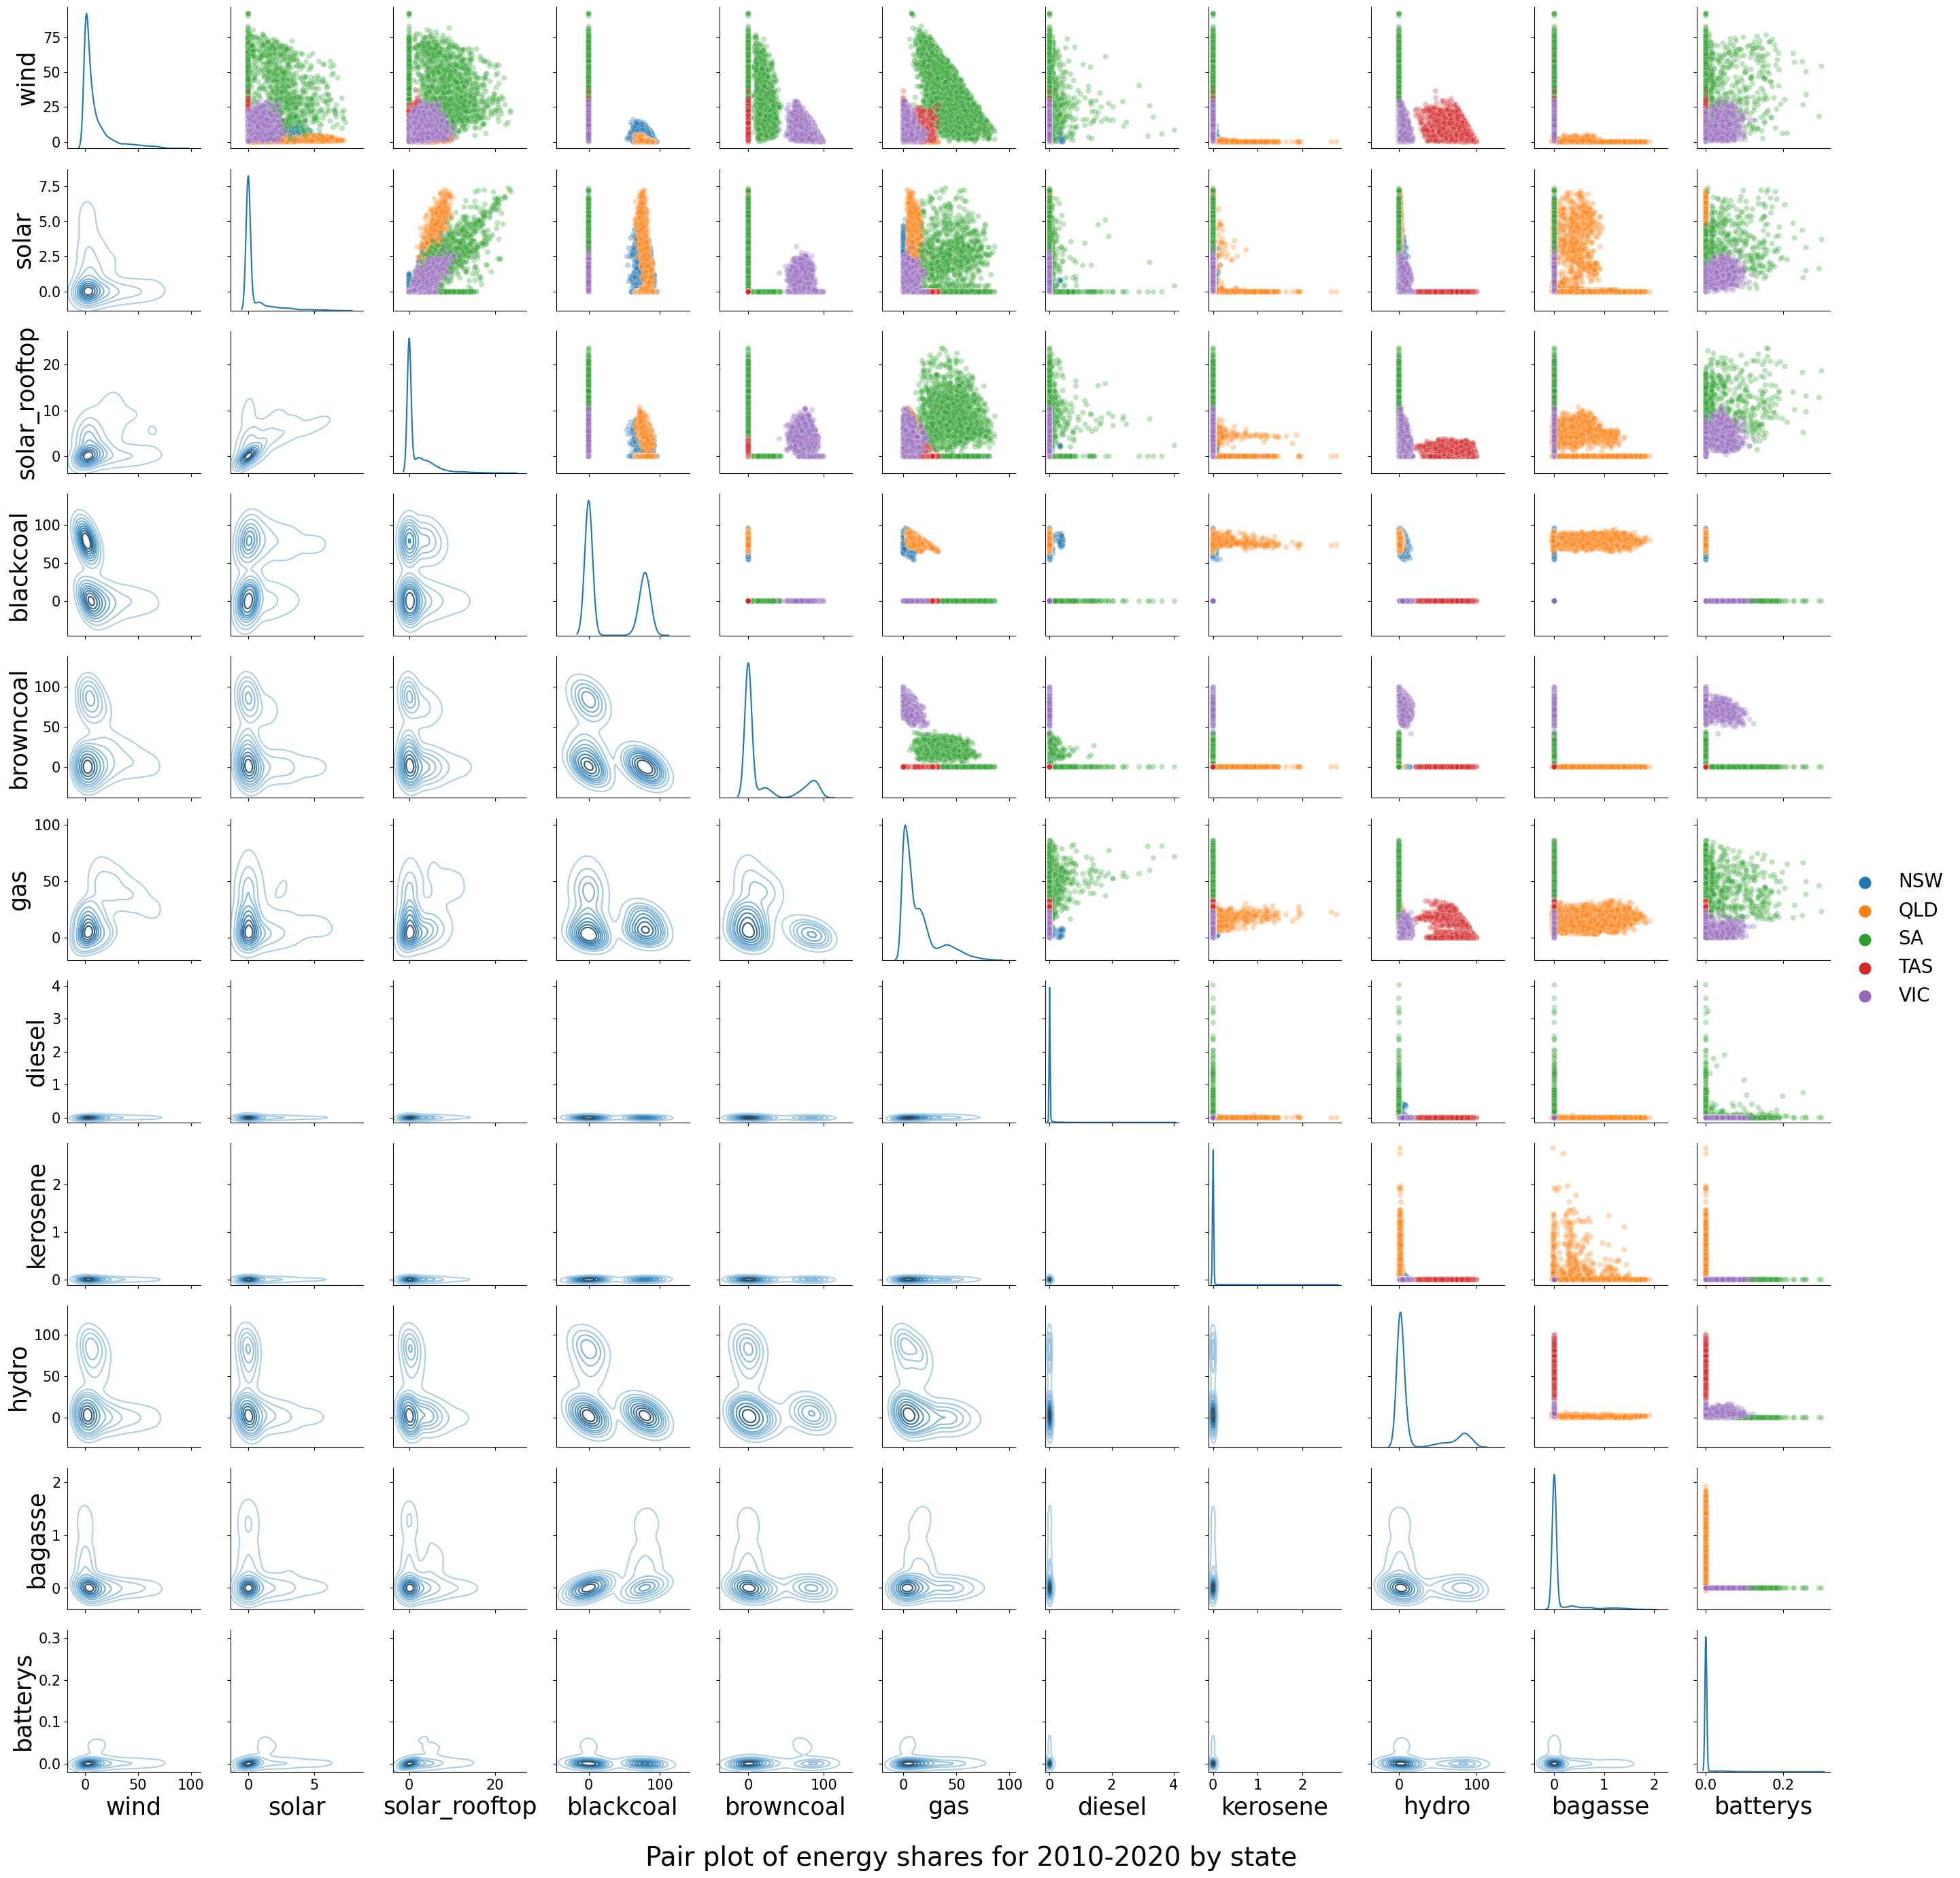

In [7]:
plt.style.use('default')
SMALL_SIZE = 15
MEDIUM_SIZE = 25
plt.rc('font', size=SMALL_SIZE)         
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('xtick', labelsize=SMALL_SIZE) 
plt.rc('ytick', labelsize=SMALL_SIZE) 
plt.rc('legend', fontsize=MEDIUM_SIZE, markerscale = 2)  

g = sns.PairGrid(X, vars = print_cols, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap = "Blues_d", bw_adjust = 2)
g.map_diag(sns.kdeplot, legend=False)
# https://stackoverflow.com/questions/54554925/is-there-a-way-to-apply-hue-only-to-lower-part-of-pairgrid-in-seaborn
g.hue_vals = X["state"]
g.hue_names = X['state'].unique()
g.palette = sns.color_palette("husl", len(g.hue_names))
g._hue_var ='state'
g.map_upper(sns.scatterplot, alpha = 0.3).add_legend(title='', fontsize = 20)

plt.suptitle('Pair plot of energy shares for 2010-2020 by state', size = 28, y=0)

# https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.savefig.html, orientation='portrait'/landscape
plt.savefig('plots/figure1.pdf')
plt.savefig('plots/figure1.png')

## Figure 2 - TSNE reducted dimension view

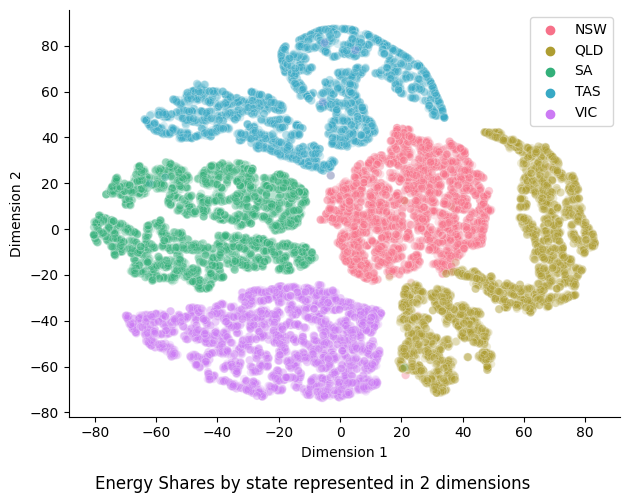

In [8]:
plt.style.use('default')
Z = pd.DataFrame(pickle.load(open('models/ftz_daily_30.pkl', 'rb')))
Z = Z.rename(columns={0: "dim1", 1: "dim2"})
Z['state'] = df['state'].astype('str').astype('category')

sns.scatterplot(x="dim1", y="dim2", hue="state", data=Z, edgecolors='none', alpha = 0.2, palette='husl')
sns.despine()
plt.tight_layout()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.gca().legend().set_title('')
plt.suptitle('Energy Shares by state represented in 2 dimensions ', y=0)
plt.savefig('plots/figure2.pdf')
plt.savefig('plots/figure2.png')

## Figure 3 Clustering optimal number

In [10]:
result = pickle.load(open('models/bgmm_results.pkl', 'rb'))

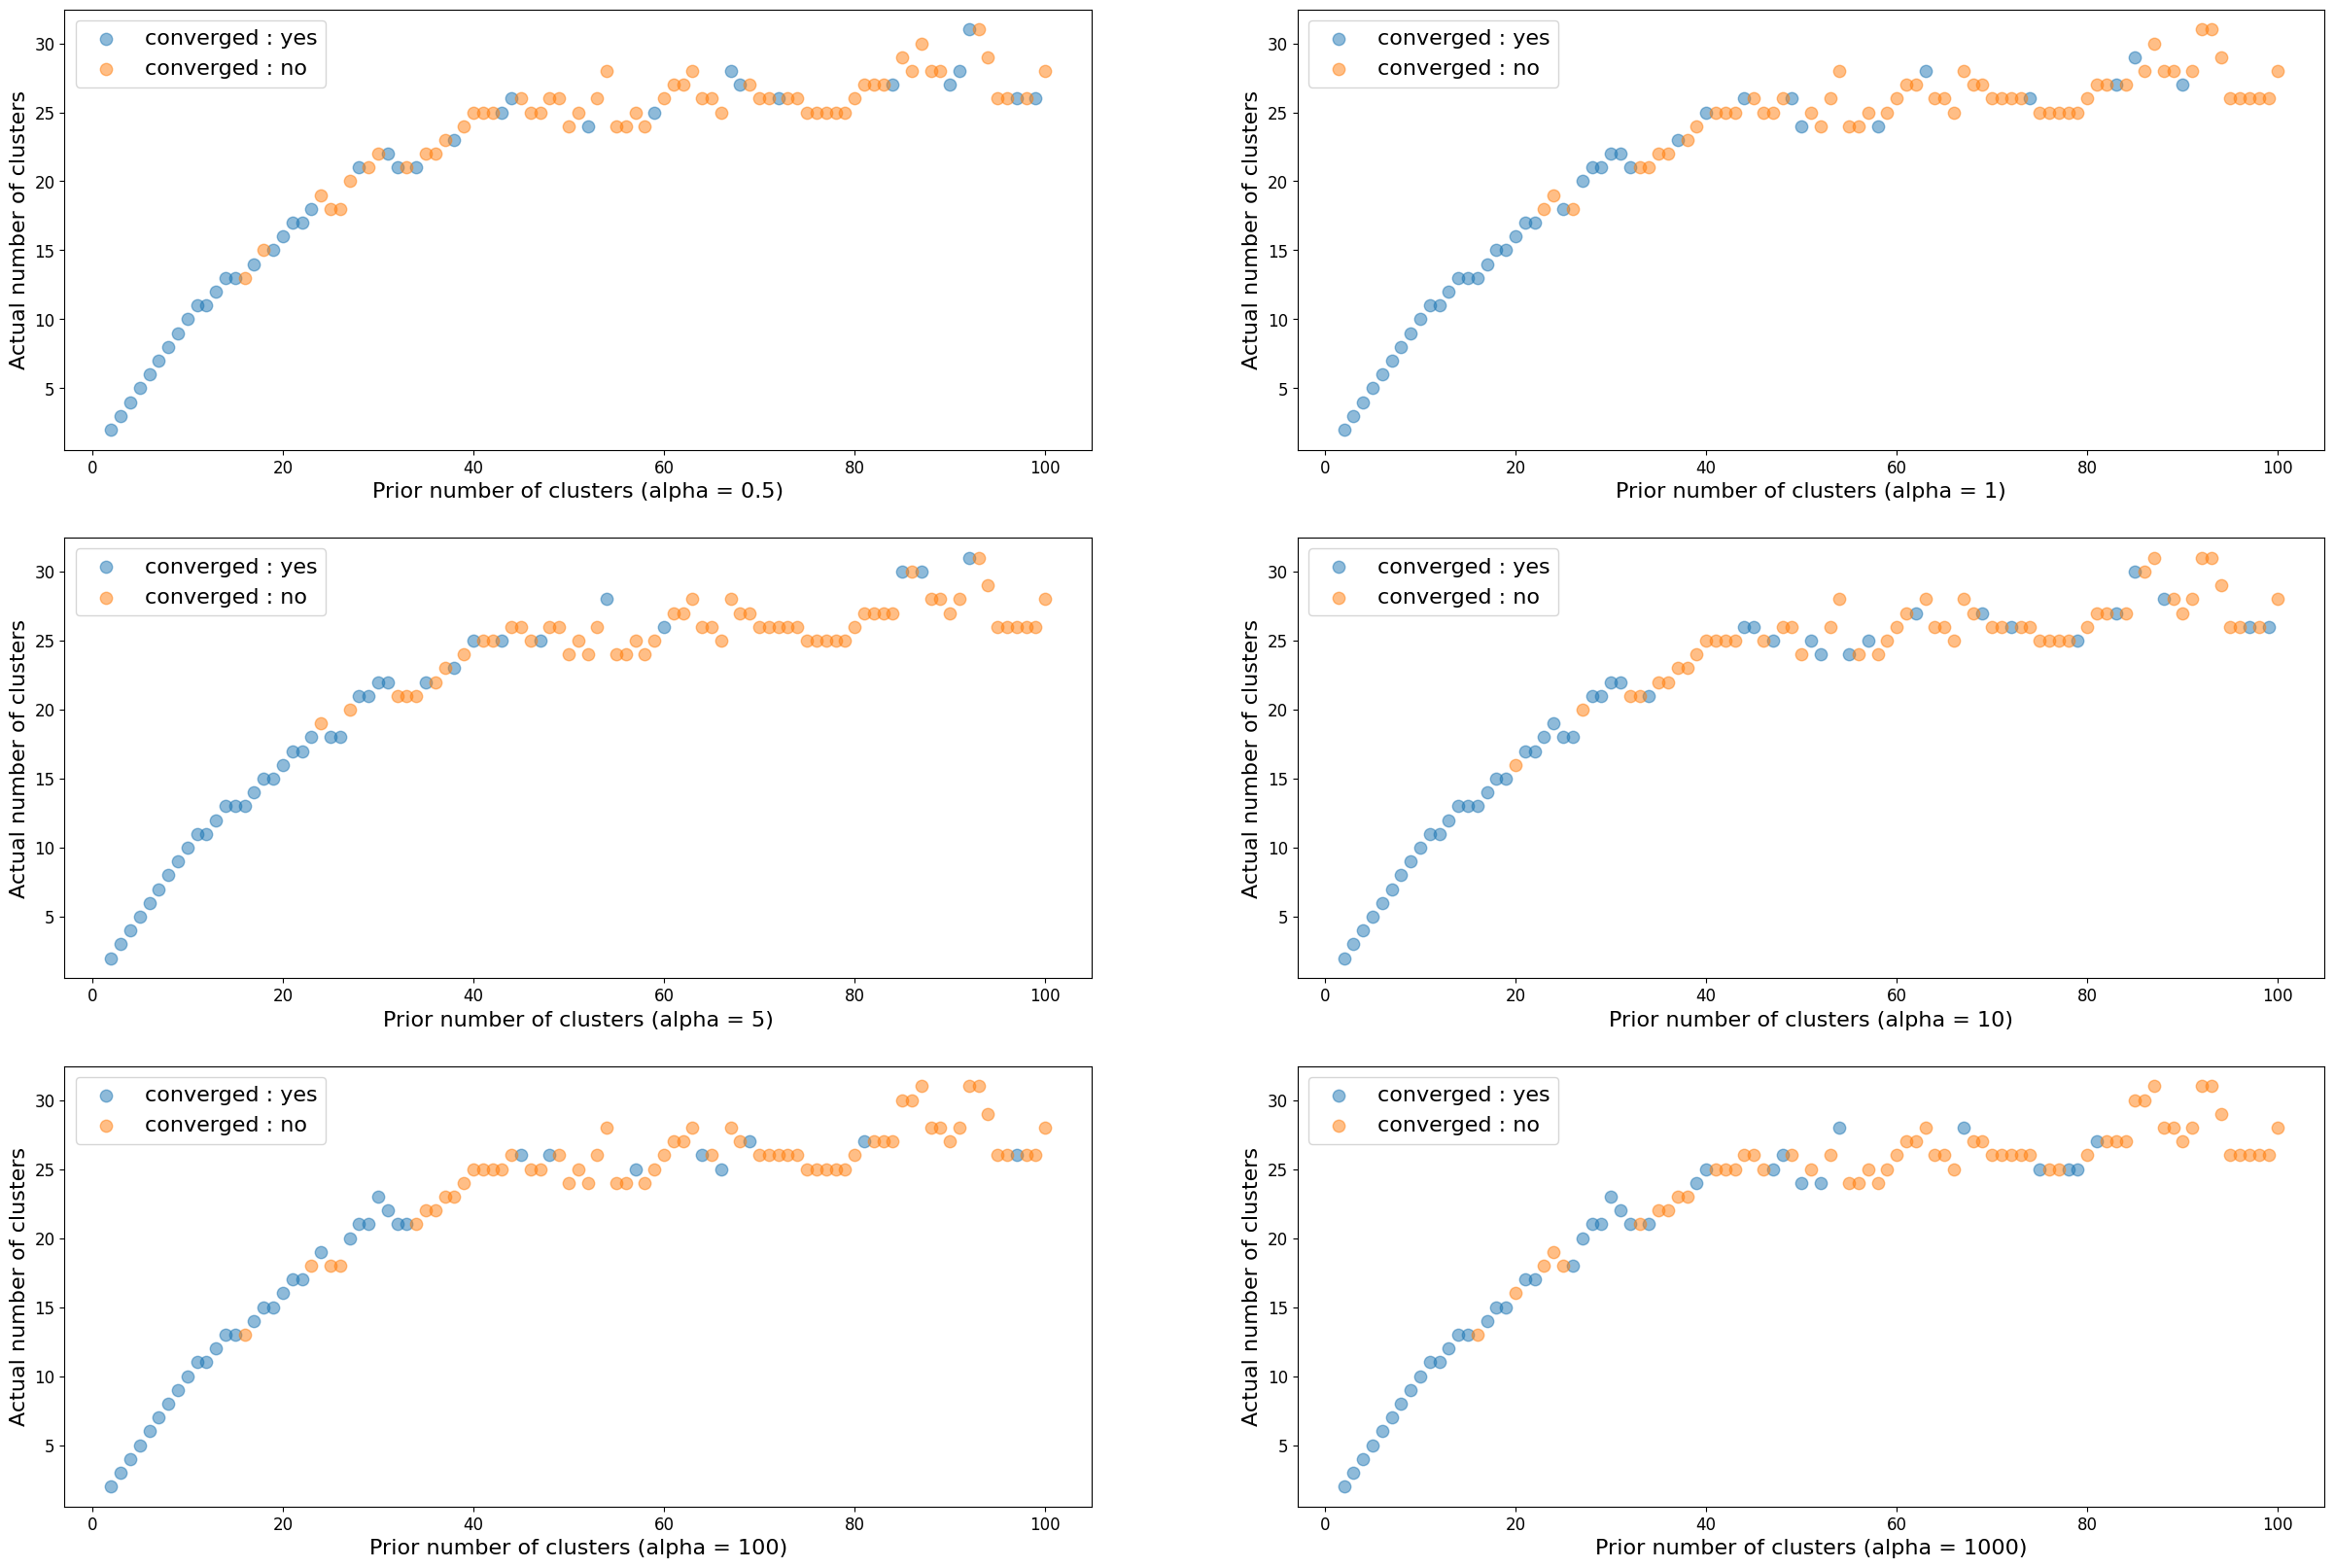

In [11]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(30,20))

def plot_optimal_cluster_all(alpha, idx):
    sub_result = result[result.alpha == alpha]
    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax[idx].scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax[idx].scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    ax[idx].legend(loc='best', fontsize = 16)
    ax[idx].set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax[idx].set_ylabel('Actual number of clusters')
    ax[idx].xaxis.label.set_size(16)
    ax[idx].yaxis.label.set_size(16)
    ax[idx].tick_params(axis='both', which='major', labelsize=12)


plot_optimal_cluster_all(0.5, (0,0))
plot_optimal_cluster_all(1, (0,1))
plot_optimal_cluster_all(5, (1,0))
plot_optimal_cluster_all(10, (1,1))
plot_optimal_cluster_all(100, (2,0))
plot_optimal_cluster_all(1000, (2,1))

fig.savefig('plots/figure3.pdf', facecolor='white', transparent = False)
fig.savefig('plots/figure3.png', facecolor='white', transparent = False)

## Figure 4 Cluster shares (by generation sources)

In [15]:
X = df[['clust'] + fuel_cols]
X = X.groupby(['clust']).agg(['mean', 'std']).reset_index().apply(lambda x: round(x, 2))
X = X.rename(columns = {'clust' : 'cluster'})
X = X.fillna('-')
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(HTML(X.to_html(index = False))) 
# X.to_csv('results/internal_cluster_shares.csv', index = False)
# to save: https://blog.ouseful.info/2019/01/16/converting-pandas-generated-html-data-tables-to-png-images/

## Figure 5 Cluster shares (by energy mixes)

In [16]:
X = df[['clust'] + additional_cols]
X = X.groupby(['clust']).agg(['mean', 'std']).reset_index().apply(lambda x: round(x, 2))
X = X.rename(columns = {'clust' : 'cluster'})
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(HTML(X.to_html(index = False))) 
# X.to_csv('results/external_cluster_shares.csv', index = False)

## Figure 6 Average prices

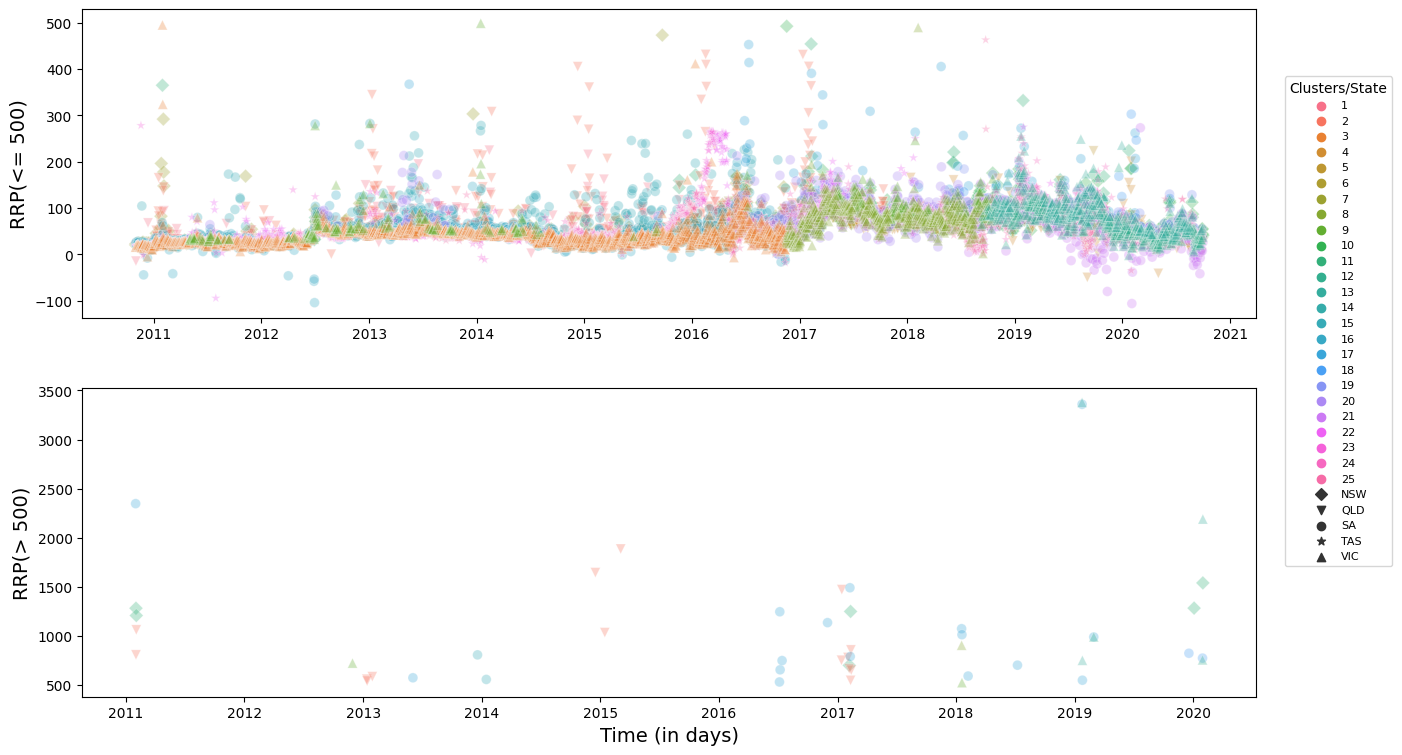

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(13, 8))
fig.tight_layout(pad=3.0)
X = df[df.rrp <= 500]
mkr_dict ={'NSW': 'D', 'QLD': 'v', 'SA': 'o', 'VIC':'^', 'TAS' :'*'}

g = sns.scatterplot(x = 'datetime', y = 'rrp', hue='clust_category', style='state', s = 50,
                    markers = mkr_dict, data = X, alpha = 0.3, legend='brief', ax = ax[0])
handles, labels = ax[0].get_legend_handles_labels()
labels = labels[1:26] + labels[27:]
handles = handles[1:26] + handles[27:]
lgd = g.legend(handles=handles, labels=labels, fontsize = 8,
        loc=2, ncol= 1, bbox_to_anchor=(1.02, 0.8), title = 'Clusters/State',title_fontsize = 10)

# Set labels
ax[0].set_xlabel('')
ax[0].set_ylabel('RRP(<= 500)', fontsize = 14) 

# a = plt.xticks(fontsize= 14)
# # Set y-axis label
# plt.ylabel('RRP( > 150)', )
# a = plt.xticks(fontsize= 14)

X = df[df.rrp > 500]
g1 = sns.scatterplot(x = 'datetime', y = 'rrp', hue='clust_category', style='state', s = 50,
                    markers = mkr_dict, data = X, alpha = 0.3, legend=False, ax = ax[1])

ax[1].set_xlabel('Time (in days)', fontsize = 14)
ax[1].set_ylabel('RRP(> 500)', fontsize = 14)

fig.savefig("plots/figure6.pdf", bbox_extra_artists=(lgd,), bbox_inches = 'tight', facecolor='white', transparent = False)
fig.savefig("plots/figure6.png", bbox_extra_artists=(lgd,), bbox_inches = 'tight', facecolor='white', transparent = False)

## Figure 7-11 - Energy path of states by cluster

In [9]:
X = df[['state', 'year', 'month', 'day', 'clust', 'probs', 'datetime']]
X = helper.get_cluster_assignment_day(X)

months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
X.loc[:,'month'] = pd.Categorical(X['month'].map(lambda x: months[x-1]), categories=months, ordered=True)

# X = X.pivot_table(index = ['state', 'month'], columns =['year', "day"], values = "clust")

In [10]:
sns.reset_orig()

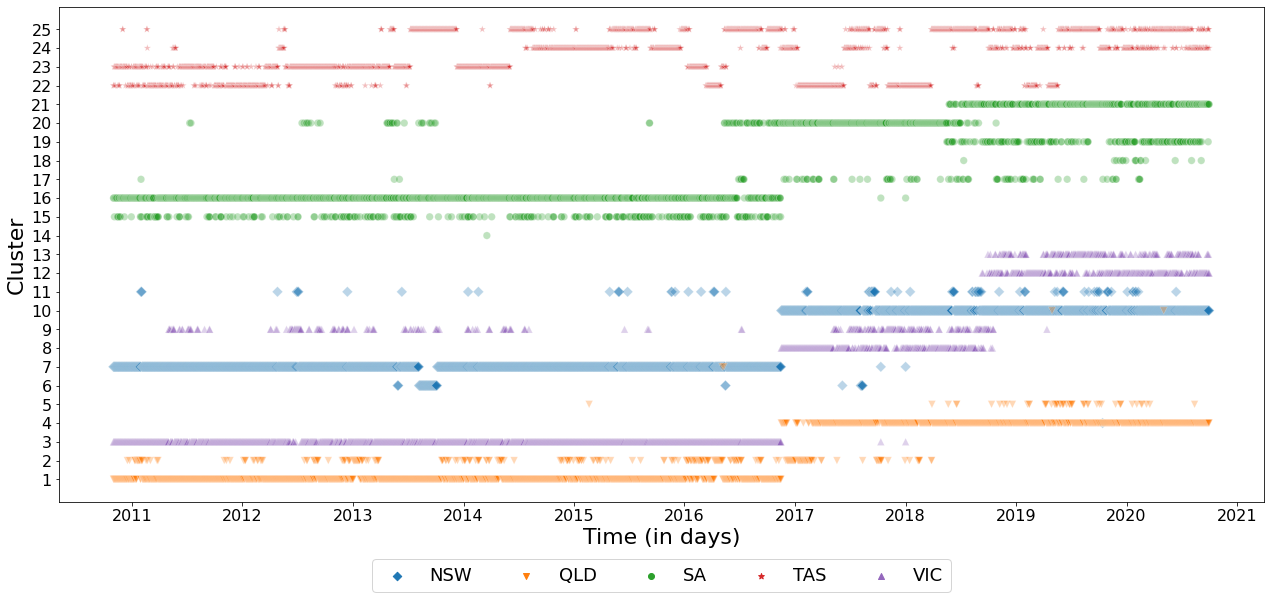

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
fig.tight_layout(pad=3.0)
X = df.copy()
mkr_dict ={'NSW': 'D', 'QLD': 'v', 'SA': 'o', 'VIC':'^', 'TAS' :'*'}
# sns.reset_orig()
# sns.set(font_scale = 2.5)
g = sns.scatterplot(x = 'datetime', y = 'clust', hue='state', style='state', s = 55,
                    markers = mkr_dict, data = X, alpha = 0.3, legend='brief', ax = ax)
yticks = np.linspace(1, 25, 25, dtype=np.int)
ax.set_yticks(yticks)
# ax.set_xticklabels(labels = list(range(2011, 2022)), fontdict = {'fontsize': 16})
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
handles, labels = ax.get_legend_handles_labels()
lgd = g.legend(handles=handles, labels=labels, fontsize = 18,
        loc=8, ncol= 5,title = '',title_fontsize = 10,  bbox_to_anchor=(0.5, -0.20))
ax.set_xlabel('Time (in days)', fontsize = 22) 
ax.set_ylabel('Cluster', fontsize = 22)
fig.savefig("plots/figure12.pdf", bbox_extra_artists=(lgd,), bbox_inches = 'tight', facecolor='white', transparent = False, orientation = 'landscape')
fig.savefig("plots/figure12.png", bbox_extra_artists=(lgd,), bbox_inches = 'tight', facecolor='white', transparent = False, orientation = 'landscape')

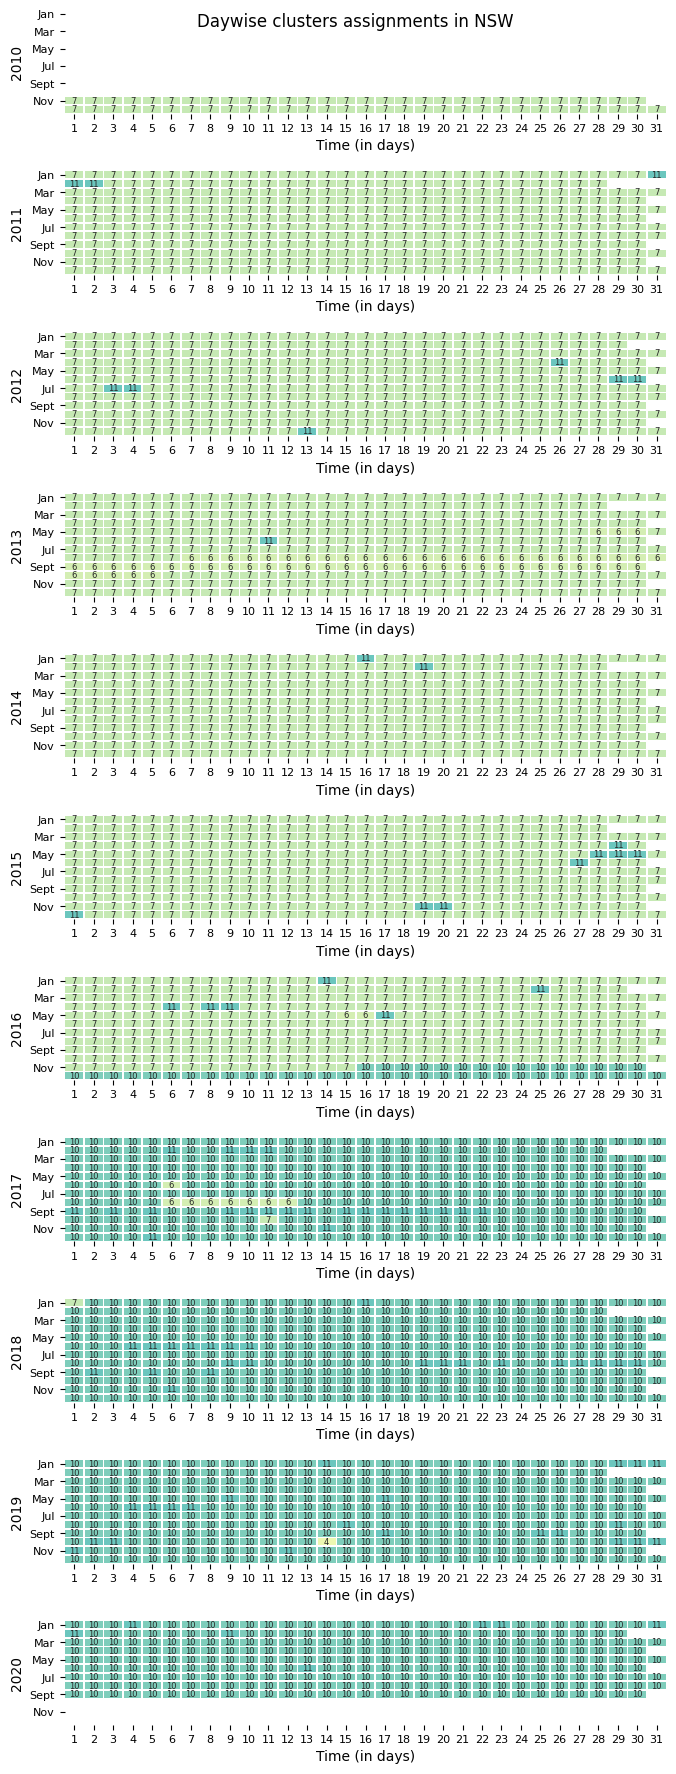

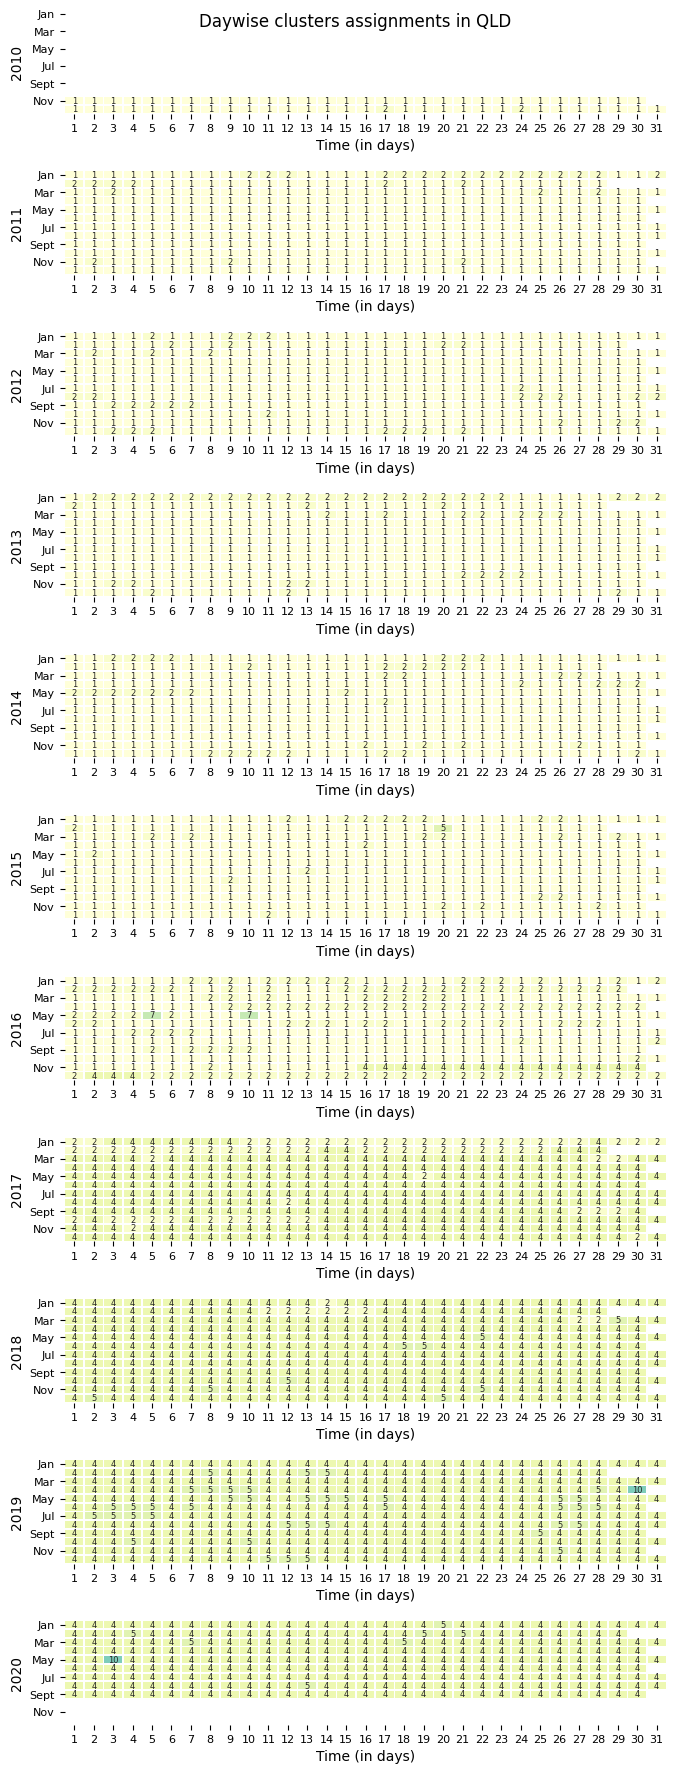

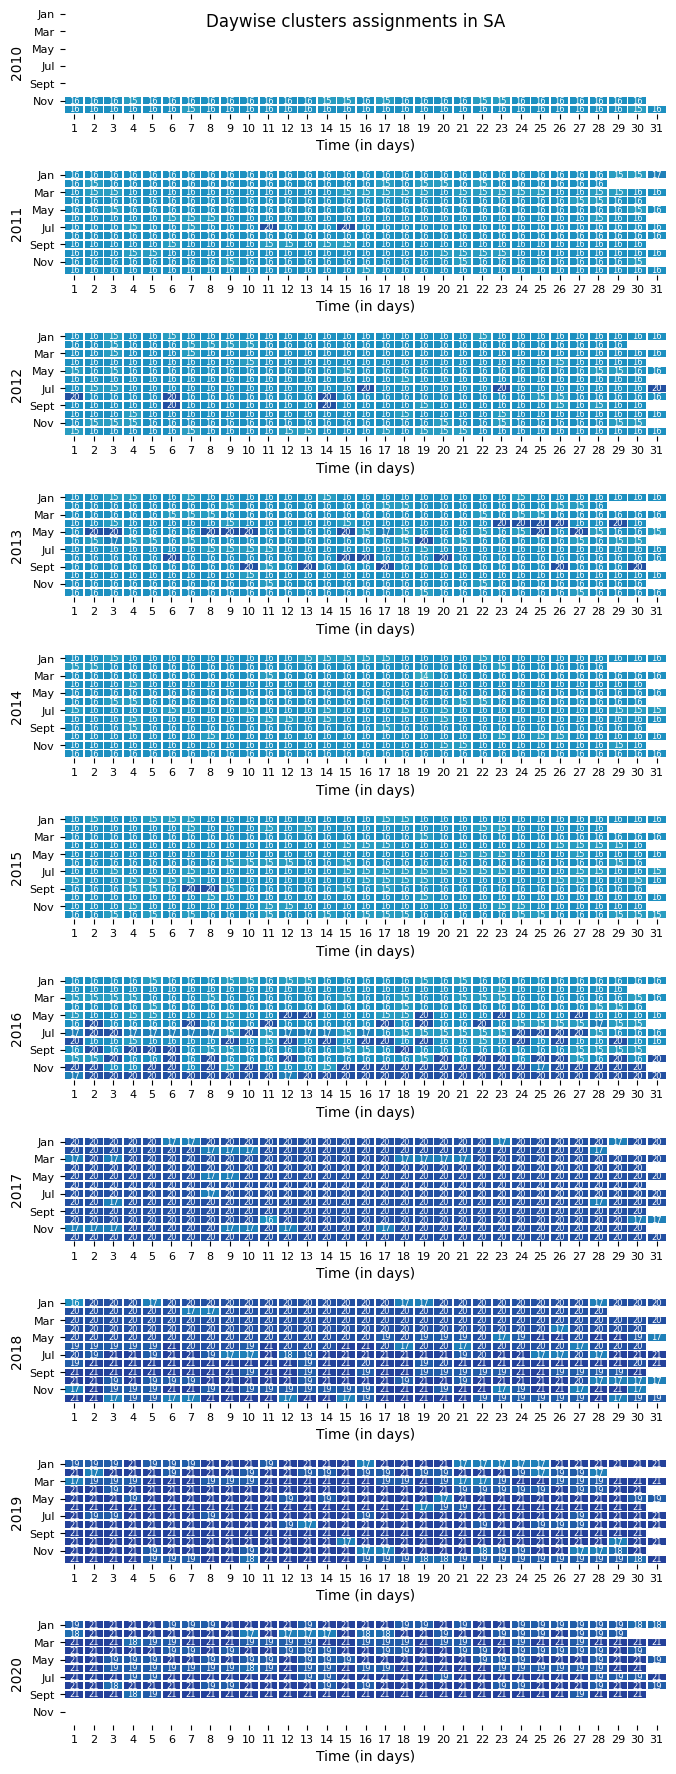

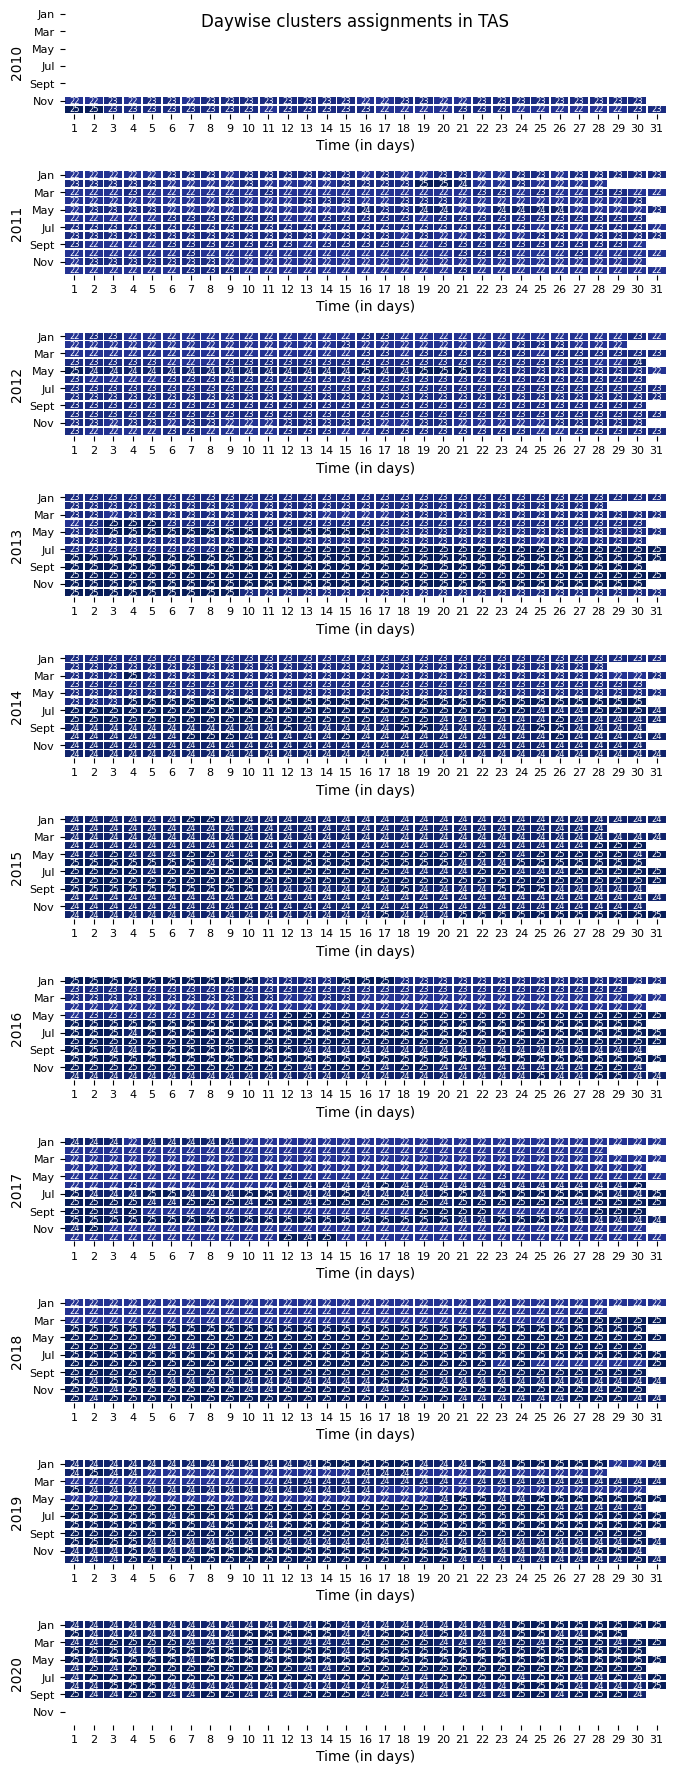

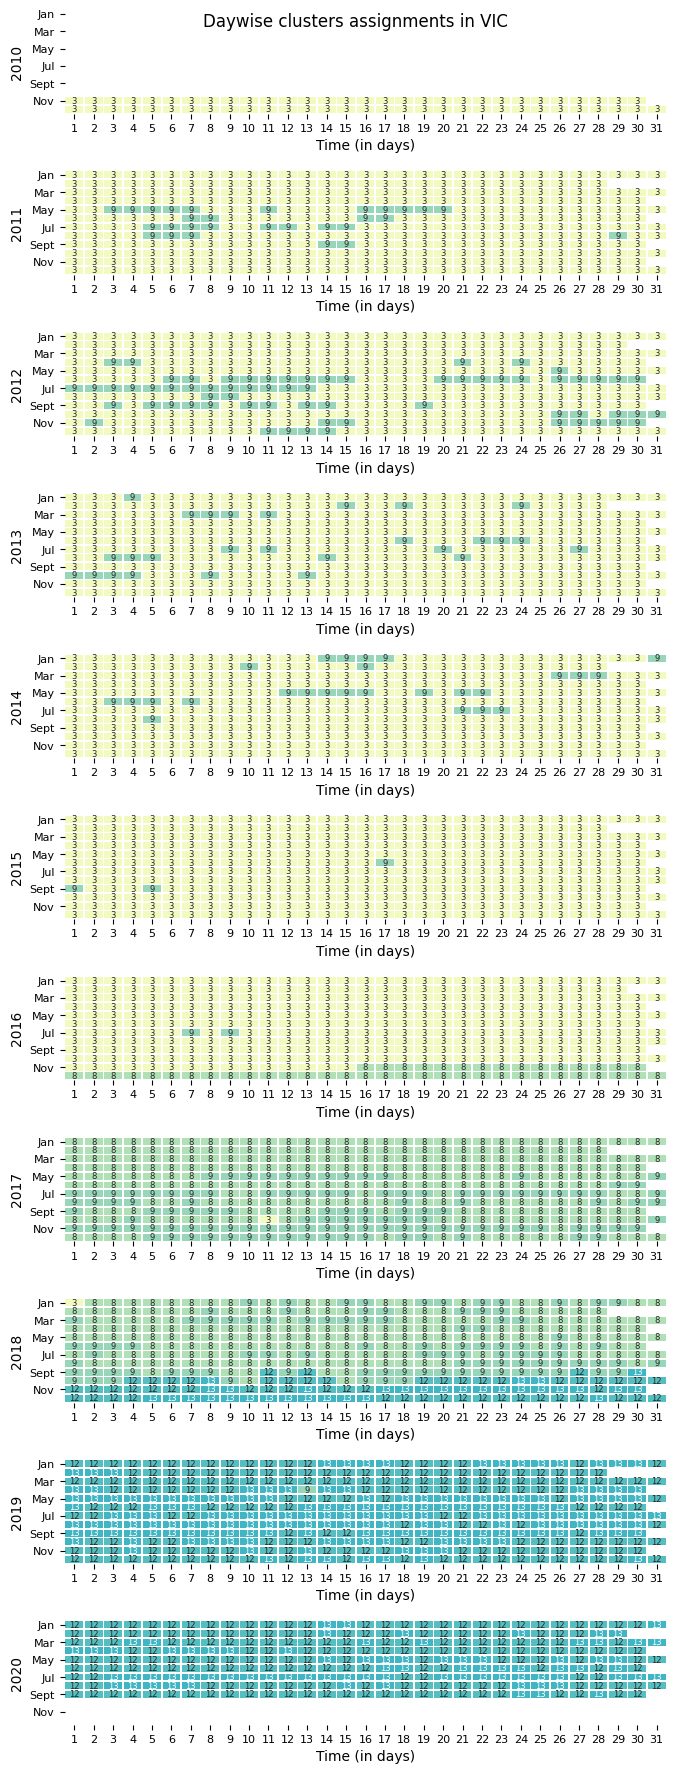

In [40]:
years = list(range(2010, 2021))
figno = 7
for state in df.state.unique():
    fig, ax = plt.subplots(11, 1, figsize=(7, 18))
    plt.subplots_adjust(top=0.85)
    fig.tight_layout(pad = 2)
    for idx in range(0, 11):
        d = X.loc[state][years[idx]]
        g = sns.heatmap(d,annot=True, vmin = 1, vmax = 25, 
                        annot_kws = {'size':'6'},
                        linewidths=.5, cmap="YlGnBu", ax = ax[idx], cbar = False,
                       mask = d.isnull())
        g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
        g.set_xticklabels(g.get_xticklabels(), fontsize = 8)
        ax[idx].set_xlabel('Time (in days)')
        ax[idx].set_ylabel('{}'.format(years[idx]))
        ax[idx].xaxis.label.set_size(10)
        ax[idx].yaxis.label.set_size(10)
    fig.suptitle('Daywise clusters assignments in {}'.format(state), y=0.98)
    fig.savefig("plots/figure{}.pdf".format(figno))
    figno = figno + 1